# Figure 12

The two-player experiment. Panel A: Average score per round, averaged over all 23 groups (left). The red dashed line shows the optimal average score for two patrons and capacity for one. Average score vs.~average go decision per player (center) and per group (right). In both plots, the regression line is shown in blue. Panel B: Six examples of game playouts. Each tile is color-coded to represent the player's decision (blue=go; gray=no go) on each of the last thirty rounds. Panel C: Distribution of Efficiency (left) and Alternation Index (center) for each experimental treatment. Efficiency vs.~Inequality for each group and color coded by experimental treatment (right). Groups showing alternating and segmented coordination are highlighted in shaded circles.

In [7]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import PIL
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportions_ztest

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.plot_utils import PlotsAndMeasures, BarRenderer

In [8]:
# Load human data
file_name = '2-player-UR.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['model'] = data['treatment']
print('Number of groups:', len(data['room'].unique()))

# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'entropy', 'conditional_entropy', 'bounded_efficiency', 'inequality'],
    T=15
)
df = gm.get_measurements()
alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation index'] = alt_index(df)
df['predicted_class'] = alt_index.classify(df)
df.sort_values(by='bounded_efficiency', inplace=True, ascending=False)

# Get average scores per treatment
av_scores = data.groupby(['treatment', 'group']).agg({
    'score':'mean',
    'decision':'mean'
}).reset_index()

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/2-player-UR.csv...
Number of groups: 23


Get best performing groups

In [9]:
print('Efficiency:')
print(df['bounded_efficiency'].describe())
best_performing_groups = df[df['bounded_efficiency'] > 0.6]['room'].values.tolist()[:9]
print('')
print('Best performing groups')
print(best_performing_groups)

Efficiency:
count    23.000000
mean      0.540761
std       0.504810
min      -0.500000
25%       0.187500
50%       0.687500
75%       1.000000
max       1.000000
Name: bounded_efficiency, dtype: float64

Best performing groups
['Grupo-0011', 'Grupo-0023', 'Grupo-0006', 'Grupo-0005', 'Grupo-0001', 'Grupo-0021', 'Grupo-0015', 'Grupo-0014', 'Grupo-0009']


Types of cooperation

In [23]:
df_ = df.groupby('treatment')['predicted_class'].value_counts(normalize=True).reset_index()
alt_perc = alt_index.alt_precentage(df, columns=['treatment'])
df_categories = pd.pivot_table(
    data=df_,
    index='treatment',
    columns='predicted_class',
    values='proportion'
).fillna('-')
df_categories

predicted_class,alternation,mixed,random,segmentation
treatment,,,,
only score,0.230769,0.076923,0.538462,0.153846
score + grid,0.400000,-,0.500000,0.100000


In [11]:
df_ = df.groupby('treatment')['predicted_class'].value_counts(normalize=False).reset_index()
df_categories = pd.pivot_table(
    data=df_,
    index='treatment',
    columns='predicted_class',
    values='count'
).fillna('-')
df_categories

predicted_class,alternation,mixed,random,segmentation
treatment,,,,
only score,3.0,1.0,7.0,2.0
score + grid,4.0,-,5.0,1.0


### Playout examples

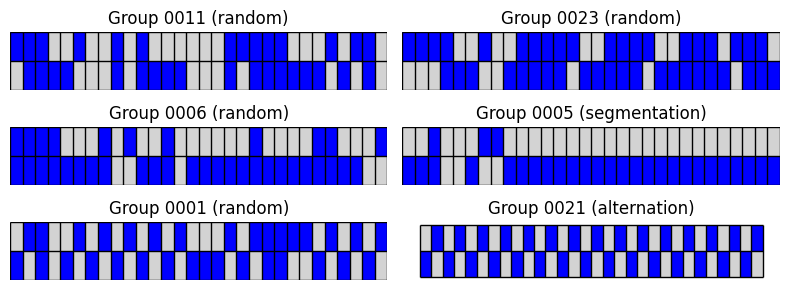

In [12]:
#-------------------------------
# Select groups
#-------------------------------
groups = [
    'Grupo-0017', 'Grupo-0022', 'Grupo-0004',
    'Grupo-0021', 'Grupo-0008', 'Grupo-0006',
]
# groups = best_performing_groups
#-------------------------------
# Plot groups
#-------------------------------
grid = Grid(len(groups))
fig, axes = plt.subplots(
    grid.rows, grid.cols, 
    figsize=(grid.cols*4, grid.rows),
    tight_layout=True
)

for i, group in enumerate(groups):
    grp = data[data['room'] == group]
    coop_type = df[df['room'] == group]['predicted_class'].unique()[0]
    bar_renderer = BarRenderer(data=grp)
    bar_renderer.render(
        ax=axes[grid.index_to_pair(i)], 
        # title=f"Group ({i+1})",
        title=f"Group {best_performing_groups[i].split('-')[-1]} ({coop_type})",
        num_rounds=30
    )

for idx in grid:
    axes[idx].set_axis_off()

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
second_row_array = np.array(pil_image)

### Average score per round

In [13]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

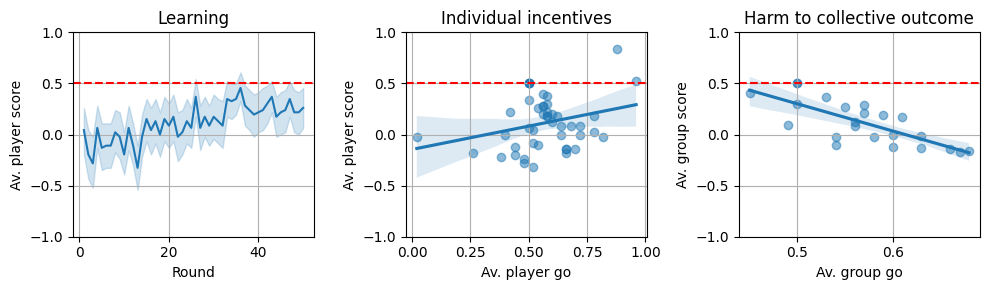

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), tight_layout=True)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning")
ax[0].grid()
ax[0].axhline(0.5, ls='--', color='red')
ax[0].set_ylim([-1,1])

# Individual incentives
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=player_av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. player go")
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Individual incentives")
ax[1].grid()
ax[1].axhline(0.5, ls='--', color='red')
ax[1].set_ylim([-1,1])

# Harm to collective outcome

sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=group_av_scores, ax=ax[2]
)
ax[2].set_xlabel("Av. group go")
ax[2].set_ylabel("Av. group score")
ax[2].set_title("Harm to collective outcome")
ax[2].grid()
ax[2].axhline(0.5, ls='--', color='red')
ax[2].set_ylim([-1,1])

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
first_row_array = np.array(pil_image)

Pearson coefficients per player

In [15]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")


Pearson correlation coefficient: 0.2775
P-value: 6.1872e-02
0.278 (p=0.062)


Pearson coefficients per group

In [16]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.7536
P-value: 3.3044e-05
-0.754 (p=0.000)


### Distribution of relevant measures

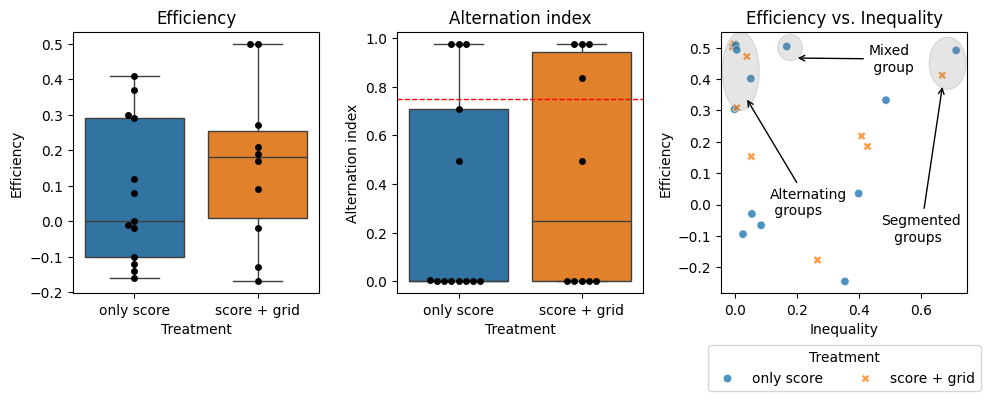

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(10,4), tight_layout=True)

# Distribution of efficiency
sns.boxplot(
    x='treatment', y='score', hue='treatment',
    data=av_scores, ax=ax[0], 
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='score', color='black',
    data=av_scores, ax=ax[0], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[0].set_xlabel('Treatment')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Efficiency')
ax[0].legend().remove()

# Distribution of alternation index per treatment
sns.boxplot(
    x='treatment', y='alternation index', hue='treatment',
    data=df, ax=ax[1], order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
sns.swarmplot(
    x='treatment', y='alternation index',
    data=df, color='black', ax=ax[1],
    order=['only score', 'score + grid'],
    hue_order=['only score', 'score + grid'],
)
ax[1].set_xlabel('Treatment')
ax[1].set_ylabel('Alternation index')
ax[1].set_title('Alternation index')
ax[1].axhline(y=alt_index.alternation_threshold, color='red', linestyle='--', linewidth=1)
ax[1].legend().remove()

# Scatter plot efficiency vs. inequality
df_jitter = df.copy()
n = df_jitter.shape[0]
df_jitter['inequality'] = df_jitter['inequality'] + np.random.normal(0,0.0075, n)
df_jitter['efficiency'] = df_jitter['efficiency'] + np.random.normal(0,0.0075, n)
sns.scatterplot(
    x='inequality', y='efficiency',
    data=df_jitter, hue='treatment', style='treatment',
    alpha=0.8, ax=ax[2],
    hue_order=['only score', 'score + grid'],
)

# Show the alternating groups on the top-left corner
circle = patches.Ellipse(
    (0.08, 0.85), width=0.15, height=0.3,
    transform=ax[2].transAxes, 
    color='gray', alpha=0.2, 
)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Alternating\n groups',
    xy=(0.1, 0.75), xycoords='axes fraction',
    xytext=(0.2, 0.3), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the mixed groups on the top center
circle = patches.Ellipse(
    (0.28, 0.94), width=0.1, height=0.1,
    transform=ax[2].transAxes, 
    color='gray', alpha=0.2, 
)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Mixed\n group',
    xy=(0.3, 0.9), xycoords='axes fraction',
    xytext=(0.6, 0.85), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Ellipse(
    (0.92, 0.88), width=0.15, height=0.2,
    transform=ax[2].transAxes, 
    color='gray', alpha=0.2, 
)
ax[2].add_patch(circle)
# Add an arrow pointing to the cluster
ax[2].annotate(
    'Segmented\n   groups',
    xy=(0.9, 0.8), xycoords='axes fraction',
    xytext=(0.65, 0.2), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)
ax[2].set_xlabel('Inequality')
ax[2].set_ylabel('Efficiency')
ax[2].set_title('Efficiency vs. Inequality')
ax[2].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -.4),
    ncol=2
)

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
third_row_array = np.array(pil_image)

# Statistic tests

Difference of average efficiency between treatments using a Mann-Whitney U test.

In [18]:
scores_treatment1 = av_scores[av_scores['treatment'] == 'only score']['score']
scores_treatment2 = av_scores[av_scores['treatment'] == 'score + grid']['score']

u_stat, p_value = stats.mannwhitneyu(scores_treatment1, scores_treatment2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")
print(rf"x1 = {scores_treatment1.mean():.3f}")
print(rf"x2 = {scores_treatment2.mean():.3f}")
print(f"{u_stat:.3f} (p={p_value:.3f})")

Mann-Whitney U statistic: 53.5
P-value: 0.4949049282714102
x1 = 0.078
x2 = 0.161
53.500 (p=0.495)


Differnece in Alternation Index

In [19]:
scores_treatment1 = df[df['treatment'] == 'only score']['alternation index']
scores_treatment2 = df[df['treatment'] == 'score + grid']['alternation index']

u_stat, p_value = stats.mannwhitneyu(scores_treatment1, scores_treatment2, alternative='two-sided')

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"P-value: {p_value}")
print(rf"x1 = {scores_treatment1.mean():.3f}")
print(rf"x2 = {scores_treatment2.mean():.3f}")
print(f"{u_stat:.3f} (p={p_value:.3f})")

Mann-Whitney U statistic: 59.0
P-value: 0.7307184018463061
x1 = 0.318
x2 = 0.426
59.000 (p=0.731)


Difference in proportion of Alternation Percentage

In [20]:
# Input data
# x = number of successes in each group
# n = number of trials in each group
x = alt_perc['alternation']
n = alt_perc['count'] 

# Two-proportion z-test
stat, p_value = proportions_ztest(count=x, nobs=n, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"x1 = {x[0]:.3f}")
print(f"x2 = {x[1]:.3f}")
print(f"n1 = {n[0]:.3f}")
print(f"n2 = {n[1]:.3f}")
print(f"{stat:.3f} (p={p_value:.3f})")

Z-statistic: -0.8744
P-value: 0.3819
x1 = 3.000
x2 = 4.000
n1 = 13.000
n2 = 10.000
-0.874 (p=0.382)


# All panels for Figure 11

(np.float64(-0.5), np.float64(999.5), np.float64(399.5), np.float64(-0.5))

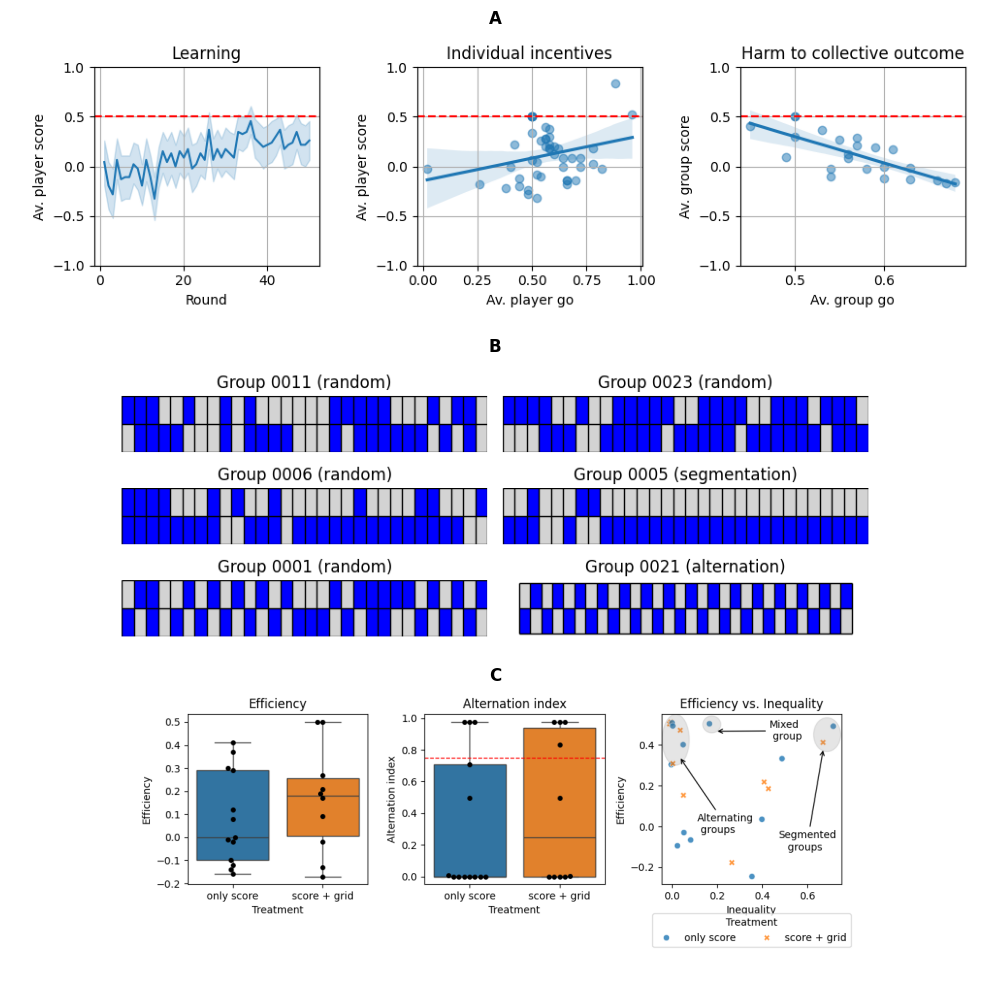

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(10,10), tight_layout=True)

ax[0].imshow(first_row_array)
ax[1].imshow(second_row_array)
ax[2].imshow(third_row_array)

ax[0].set_title('A', fontweight="bold")
ax[1].set_title('B', fontweight="bold")
ax[2].set_title('C', fontweight="bold")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [22]:
fig.savefig(PATHS['figures_for_paper'] / 'Figure12.png', dpi=300, bbox_inches='tight')

---